# Credit Card Default Demo

In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), '..'))

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from sklearn import linear_model
from recourse_methods import mrmc_method
from core import recourse_iterator

from data.datasets.credit_card_default import credit_card_default_loader
from data.adapters import continuous_adapter
from models import model_utils
from core import utils
from visualize.two_d_plots import Display2DPaths

## Load the data and model

In [2]:
data_loader = credit_card_default_loader.CreditCardDefaultLoader()
dataset = data_loader.load_data()
preprocessor = continuous_adapter.StandardizingAdapter().fit(dataset)
dataset

,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Y
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,24,2,2,0,0,0,0,3913,3102,...,0,0,0,0,689,0,0,0,0,1
2,120000,26,0,2,0,0,0,2,2682,1725,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,34,0,0,0,0,0,0,29239,14027,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,37,0,0,0,0,0,0,46990,48233,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,57,0,0,0,0,0,0,8617,5670,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,220000,39,0,0,0,0,0,0,188948,192815,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29997,150000,43,0,0,0,0,0,0,1683,1828,...,8979,5190,0,1837,3526,8998,129,0,0,0
29998,30000,37,4,3,2,0,0,0,3565,3356,...,20878,20582,19357,0,0,22000,4200,2000,3100,1


Accuracy:  0.8186333333333333


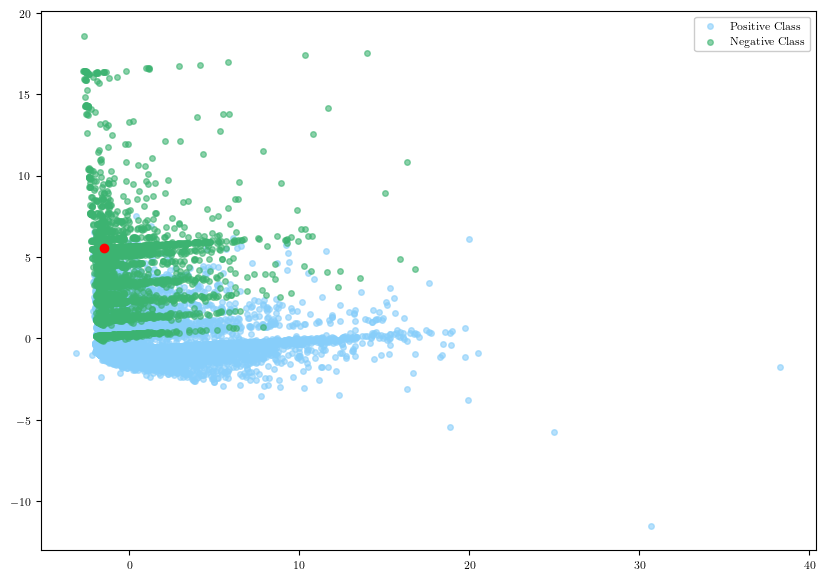

In [3]:
X = preprocessor.transform(dataset.drop('Y', axis=1)).copy().to_numpy()
y = dataset['Y'].copy().to_numpy()

model = linear_model.LogisticRegression(penalty='none')
model.fit(X, y)

y_pred = model.predict(X)

print("Accuracy: ", (y == y_pred).sum() / y.size)

dataset.loc[:,'Y'] = 0
dataset.loc[y_pred == 1,'Y'] = 1

poi = utils.random_poi(dataset, column='Y', label=1)

fig, ax = Display2DPaths(
    preprocessor.transform(dataset.drop('Y', axis=1)).to_numpy(),
    dataset['Y'].to_numpy(),
    positive_label = 0
).set_poi(preprocessor.transform_series(poi)).do_pca().scatter()

## Generate some recourse directions

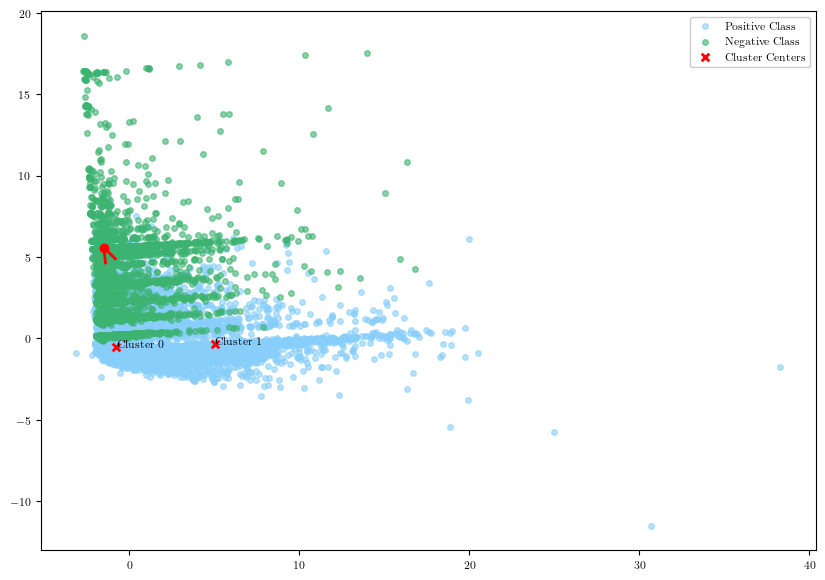

In [4]:
k_directions = 2
mrmc = mrmc_method.MRMC(
    k_directions,
    preprocessor,
    dataset,
    label_column='Y',
    positive_label=0,
    rescale_direction=mrmc_method.get_constant_step_size_rescaler(1))
poix = preprocessor.transform_series(poi)
dirs = mrmc.get_all_recourse_directions(poix)

fig, ax = Display2DPaths(
    preprocessor.transform(dataset.drop('Y', axis=1)).to_numpy(),
    dataset['Y'].to_numpy(),
    positive_label=0,
).do_pca().set_poi(poix).set_dirs(dirs, poix).set_clusters(mrmc.clusters.cluster_centers).scatter()

## Generate some paths

final certainty for path 0: 1.0
final certainty for path 1: 1.0


(<Figure size 1000x700 with 1 Axes>, <AxesSubplot:>)

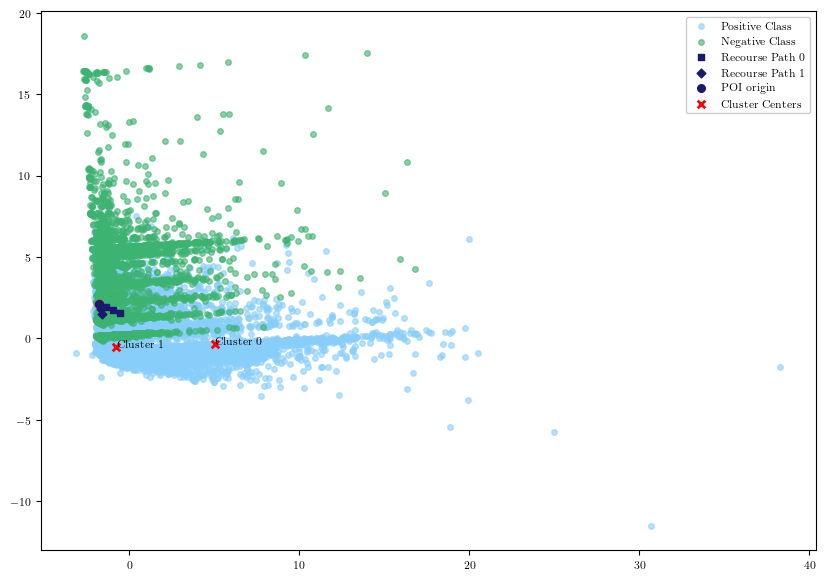

In [5]:
check_certainty = recourse_iterator.wrap_model(model, positive_index=0)

mrmc = mrmc_method.MRMC(
    k_directions,
    preprocessor,
    dataset,
    label_column='Y',
    positive_label=0,
    rescale_direction=mrmc_method.get_constant_step_size_rescaler(0.5))

display = Display2DPaths(
    preprocessor.transform(dataset.drop('Y', axis=1)).to_numpy(),
    dataset['Y'].to_numpy(),
    positive_label=0
)

poi = utils.random_poi(dataset, column='Y', label = 1)

iterator = recourse_iterator.RecourseIterator(
    mrmc,
    preprocessor,
    certainty_cutoff=0.5,
    check_certainty=check_certainty)
paths = iterator.iterate_k_recourse_paths(poi, 10)

for i, path in enumerate(paths):
    print(f'final certainty for path {i}: {check_certainty(path.iloc[-1])}')

transformed_paths = [preprocessor.transform(path) for path in paths]

display.do_pca().set_poi(preprocessor.transform_series(poi)).set_paths(transformed_paths).set_clusters(mrmc.clusters.cluster_centers).scatter()

## What features are changed?

In [6]:
paths[0]

,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,200000.000000,38.000000,2.000000,0.000000,2.000000,2.000000,0.000000,0.000000,166.000000,1694.000000,1519.000000,0.000000,0.000000,600.000000,1694.000000,0.000000,0.000000,0.000000,600.000000,0.000000
1,203367.002810,37.885630,1.867985,0.007240,1.867581,1.866481,0.005516,0.006549,12011.827519,13151.437273,12565.364287,10321.076527,9591.633794,9775.873581,2375.308583,810.074838,669.596876,609.446349,1172.354174,605.801749
2,206635.652764,37.769226,1.735350,0.014399,1.734582,1.732348,0.010905,0.012982,23848.457244,24594.252895,23595.021357,20626.691485,19169.375210,18939.182314,3040.201722,1602.810889,1323.779421,1205.784015,1731.887834,1198.340151
3,209786.893053,37.650323,1.601979,0.021432,1.600881,1.597476,0.016117,0.019253,35671.555732,36017.299612,34602.885638,30912.861702,28730.261163,28087.523366,3685.945738,2375.243257,1960.267613,1787.061257,2276.620629,1775.599381


In [7]:
paths[1]

,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,200000.000000,38.000000,2.000000,0.000000,2.000000,2.000000,0.000000,0.000000,166.000000,1694.000000,1519.000000,0.000000,0.000000,600.000000,1694.000000,0.000000,0.000000,0.000000,600.000000,0.000000
1,194815.118699,37.664906,1.782699,0.018757,1.787177,1.781166,0.008985,0.009590,3080.236172,4198.211002,3842.908132,2237.916228,2043.212014,2479.357373,1916.068108,427.195338,372.359300,343.853927,869.436411,358.293346
2,189635.260551,37.327040,1.566001,0.036079,1.573533,1.561671,0.017071,0.018356,5931.460957,6640.944416,6107.411645,4420.049372,4032.492180,4305.378644,2129.041506,844.356679,735.537226,677.528657,1129.205067,704.745075
